In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
donors_csv = f"./output/donors_agg_pred_lastname_trunc.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
0,1,ampac ampac,[24I Contribution],Z9500,,NaN,WASHINGTON,DC,379351224.0,30966,12250.572370,1000.0,0.000000,False,2000,Party
1,,,[Candidate Contribution],Y4000,,NaN,NaN,,144446528.0,19266,7497.484065,300.0,0.000000,False,2000,Unknown
2,a0000305213,steve forbes,[Candidate Contribution],Z9000,M,NaN,NaN,,7050000.0,11,640909.090909,750000.0,0.016339,False,2000,Party
3,U00000003381,s daniel abraham,Slim-Fast Foods,H4600,M,NaN,WEST PALM BEACH,FL,1615500.0,53,30481.132075,1000.0,0.248928,False,2000,Health
4,U00000002531,bernard l schwartz,Loral Space & Communications,C4400,M,NaN,NEW YORK,NY,1355000.0,44,30795.454545,20000.0,0.000000,False,2000,Tech
5,U00000002811,peter l buttenwieser,Peter L Buttenwieser & Assoc,J1200,M,NaN,PHILADELPHIA,PA,1307700.0,63,20757.142857,5000.0,0.000000,False,2000,Ideology/Single Issue
6,U00000003801,haim saban,Saban Entertainment,C2400,M,NaN,LOS ANGELES,CA,1250000.0,39,32051.282051,1000.0,0.340212,False,2000,Tech
7,U00000000041,carl h lindner,American Financial Group,F3100,M,NaN,CINCINNATI,OH,1187490.0,52,22836.346154,1000.0,0.000000,False,2000,Finance
8,U00000041441,davidi gilo,Vyyo Inc,C4600,N,NaN,WOODSIDE,CA,1144500.0,22,52022.727273,1000.0,0.880770,False,2000,Tech
9,U0000004191,constance milstein,Milstein Properties,F4500,F,NaN,NEW YORK,NY,959515.0,32,29984.843750,4257.5,0.002620,False,2000,Finance


In [4]:
donors[donors["indian"] == True].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
15394789,U0000004761,nishad singh,FTX.US,F2800,M,DIRECTOR OF ENGINEERING,LOS ALTOS HILLS,CA,8476000.0,148,57270.270270,2900.0,32.637847,True,2022,Finance
7535179,U0000003169,philip munger,Investor,F7000,M,INVESTOR,NEW YORK,NY,4881929.0,325,15021.320000,2700.0,0.180377,True,2016,Finance
9971305,h3003465387,shiva ayyadurai,[Candidate Contribution],Z9000,M,CHAIRMAN & CEO,CAMBRIDGE,MA,4817653.0,39,123529.564103,3133.0,3.302889,True,2018,Party
11805965,U00000033011,vinod khosla,Khosla Ventures,F2500,M,VENTURE CAPITALIST,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,58.605447,True,2020,Finance
15394949,U00000033011,vinod khosla,Khosla Ventures,F2500,M,VENTURE CAPITALIST,PORTOLA VALLEY,CA,2084900.0,30,69496.666667,5000.0,58.605447,True,2022,Finance
7535269,U0000004128,charles t jr munger,SLAC National Accelerator Laboratory,X3000,M,PHYSICIST,PALO ALTO,CA,1888200.0,57,33126.315789,2700.0,0.112439,True,2016,NaN
7535284,U00000035581,muneer a satter,Satter Investment Management,F2600,M,PRIVATE INVESTOR,CHICAGO,IL,1739100.0,69,25204.347826,2700.0,0.428483,True,2016,Finance
11806080,m0001327150,sameer gandhi,Accel Partners,F2500,M,VENTURE CAPITALIST,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,25.319363,True,2020,Finance
9971391,U0000003169,philip munger,Investor,F7000,M,INVESTOR,NEW YORK,NY,1628961.0,202,8064.163366,2700.0,0.180377,True,2018,Finance
7535314,U00000003781,amy joyce rao,Integrated Archive Systems,C5130,F,CEO,PALO ALTO,CA,1495229.0,567,2637.088183,200.0,8.309695,True,2016,Tech


In [5]:
donors["sector"].value_counts()

sector
Unknown                  3354516
Finance                  1825155
Health                   1747553
Party                    1474022
Law                      1061696
Ideology/Single Issue    1006711
Tech                      589973
Construction              478363
Transportation            461525
Labor                     434577
Energy                    341157
Agribusiness              329532
Education                 271288
Media                     226442
Manufacturing             207594
Defense                   129649
Name: count, dtype: int64

In [6]:
population = pd.read_csv("./data/aapi_population.csv")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2014,Alabama,AL,11754,4841799,0.242761
1,2014,Alaska,AK,0,736283,0.000000
2,2014,Arizona,AZ,39764,6730413,0.590811
3,2014,Arkansas,AR,8035,2967392,0.270776
4,2014,California,CA,607297,38596972,1.573432
5,2014,Colorado,CO,20342,5350101,0.380217
6,2014,Connecticut,CT,49204,3594524,1.368860
7,2014,Delaware,DE,13349,932487,1.431548
8,2014,District of Columbia,DC,136461,662328,20.603236
9,2014,Florida,FL,130382,19845911,0.656972


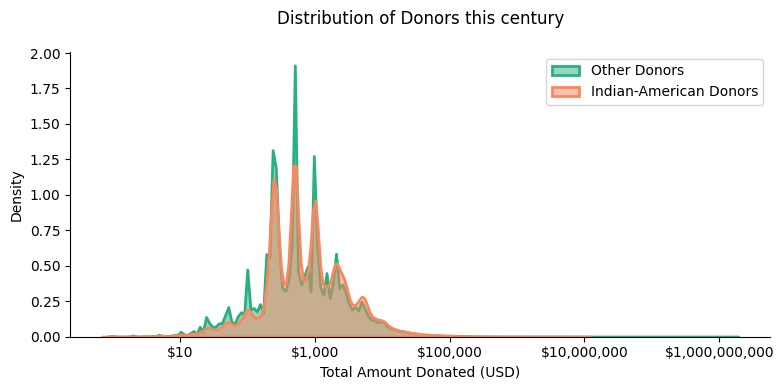

In [7]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['indian'] == False]['total_donated'],
            label='Other Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)
sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['indian'] == True]['total_donated'],
            label='Indian-American Donors',
            color='#fb8761',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors this century", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [8]:
donors_grouped = donors.groupby(['cycle', 'indian']).agg({'contrib_id': 'nunique'}).reset_index()
donors_grouped['indian'] = donors_grouped['indian'].replace({True: 'Indian-Americans', False: 'Other Donors'})
donors_pivot = donors_grouped.pivot(index='cycle', columns='indian', values='contrib_id').fillna(0)

population["cycle"] = population["Year"].apply(lambda x: int(str(x)[:4]))
population_grouped = population.groupby('cycle').agg({'Indian Pop': 'sum', 'Census Pop': 'sum'}).reset_index()
donors_pivot = donors_pivot.merge(population_grouped, on='cycle', how='left')

# from US Census
donors_pivot.loc[donors_pivot["cycle"] == 2000, "Indian Pop"] = 1645510
donors_pivot.loc[donors_pivot["cycle"] == 2010, "Indian Pop"] = 2843391
donors_pivot.loc[donors_pivot["cycle"] == 2000, "Census Pop"] = 281421906
donors_pivot.loc[donors_pivot["cycle"] == 2010, "Census Pop"] = 308745538

donors_pivot["indian_rate"] = donors_pivot["Indian-Americans"] / donors_pivot["Indian Pop"] * 100
donors_pivot["other_rate"] = donors_pivot["Other Donors"] / donors_pivot["Census Pop"] * 100
donors_pivot["indian_pop_rate"] = donors_pivot["Indian Pop"] / donors_pivot["Census Pop"] * 100

donors_pivot

,cycle,Indian-Americans,Other Donors,Indian Pop,Census Pop,indian_rate,other_rate,indian_pop_rate
0,2000,6718,774015,1645510.0,281421906.0,0.408262,0.275037,0.584713
1,2002,6042,648785,NaN,NaN,NaN,NaN,NaN
2,2004,11041,1118688,NaN,NaN,NaN,NaN,NaN
3,2006,8497,771185,NaN,NaN,NaN,NaN,NaN
4,2008,17076,1335389,NaN,NaN,NaN,NaN,NaN
5,2010,11894,808053,2843391.0,308745538.0,0.418303,0.261721,0.920950
6,2012,16464,1260150,NaN,NaN,NaN,NaN,NaN
7,2014,10336,730787,3269584.0,318301008.0,0.316126,0.229590,1.027199
8,2016,28474,2407666,3597110.0,322941311.0,0.791580,0.745543,1.113859
9,2018,25309,1809247,3996791.0,326687501.0,0.633233,0.553816,1.223429


In [9]:
amounts_grouped = donors.groupby(['cycle', 'indian']).agg({'total_donated': 'sum'}).reset_index()
amounts_grouped['indian'] = amounts_grouped['indian'].replace({True: 'Indian-Americans', False: 'Other Donors'})
amounts_pivot = amounts_grouped.pivot(index='cycle', columns='indian', values='total_donated').fillna(0)
amounts_pivot

indian,Indian-Americans,Other Donors
cycle,,
2000,9618419.0,1.838275e+09
2002,7680807.0,1.543993e+09
2004,18558416.0,2.251250e+09
2006,15617230.0,1.654763e+09
2008,35419316.0,3.347575e+09
2010,22080388.0,2.004358e+09
2012,46234096.0,4.831126e+09
2014,26355357.0,2.722092e+09
2016,82314167.0,6.667927e+09


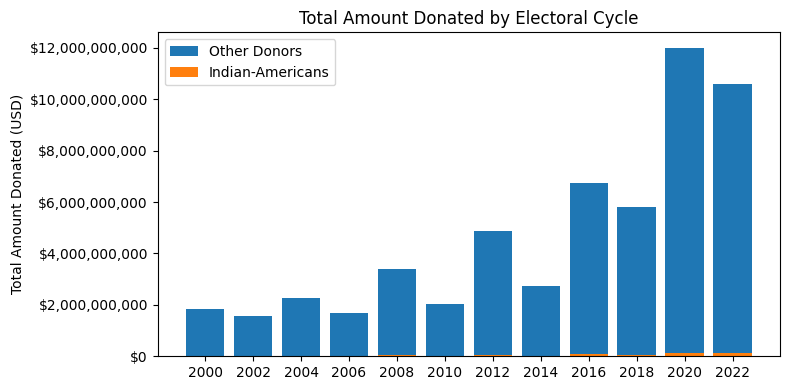

In [10]:
plt.figure(figsize=(8, 4))

cycles = pd.Series(amounts_pivot.index).apply(lambda x: str(x)[:4])
plt.bar(cycles, amounts_pivot['Other Donors'], bottom= amounts_pivot['Indian-Americans'], label='Other Donors')
plt.bar(cycles, amounts_pivot['Indian-Americans'], label='Indian-Americans')

plt.title("Total Amount Donated by Electoral Cycle")
plt.ylabel("Total Amount Donated (USD)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
plt.tight_layout()
plt.show()

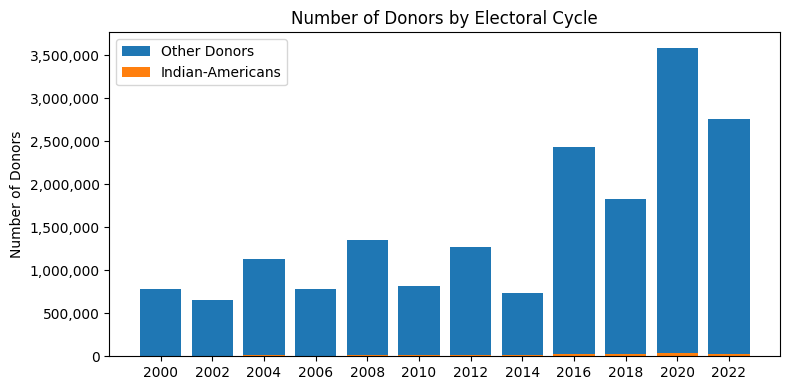

In [11]:
plt.figure(figsize=(8, 4))

cycles = pd.Series(donors_pivot["cycle"]).apply(lambda x: str(x)[:4])
plt.bar(cycles, donors_pivot['Other Donors'], bottom=donors_pivot['Indian-Americans'], label='Other Donors')
plt.bar(cycles, donors_pivot['Indian-Americans'], label='Indian-Americans')

plt.title("Number of Donors by Electoral Cycle")
plt.ylabel("Number of Donors")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.legend()
plt.tight_layout()
plt.show()

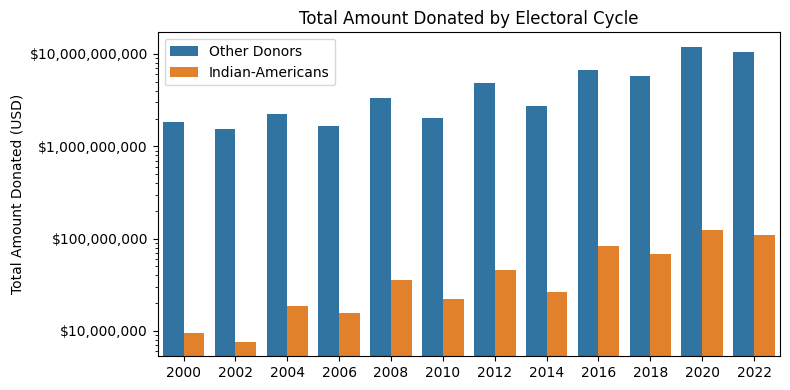

In [12]:
plt.figure(figsize=(8, 4))

sns.barplot(data=amounts_grouped, x='cycle', y='total_donated', hue='indian')

plt.title(f"Total Amount Donated by Electoral Cycle")
plt.ylabel("Total Amount Donated (USD)")
plt.yscale('log')
plt.xlabel("")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
plt.tight_layout()
plt.show()

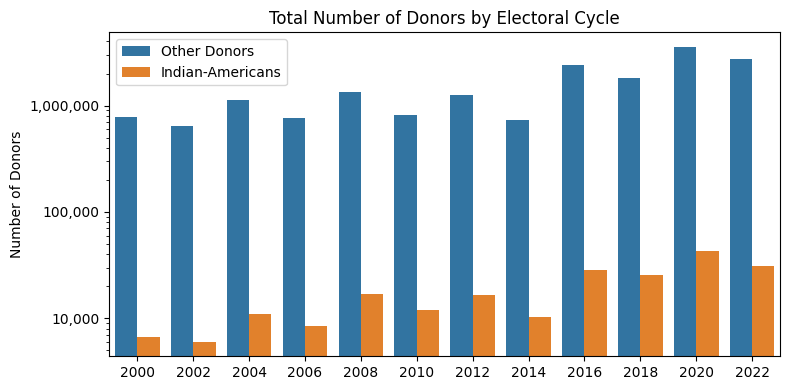

In [13]:
plt.figure(figsize=(8, 4))

sns.barplot(data=donors_grouped, x='cycle', y='contrib_id', hue='indian')

plt.title(f"Total Number of Donors by Electoral Cycle")
plt.ylabel("Number of Donors")
plt.xlabel("")
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.legend()
plt.tight_layout()
plt.show()

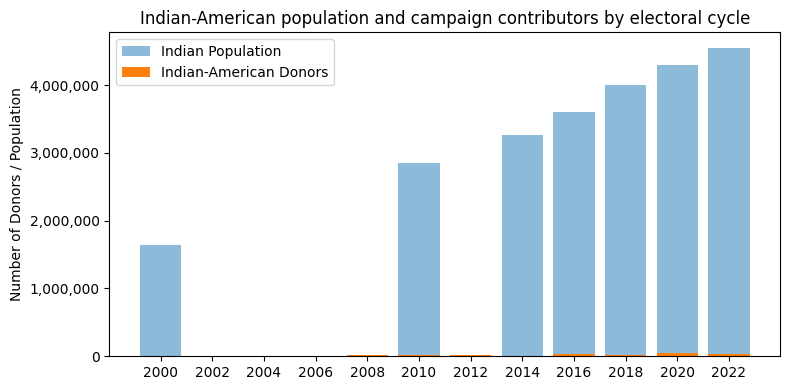

In [14]:
plt.figure(figsize=(8, 4))

cycles = pd.Series(donors_pivot["cycle"]).apply(lambda x: str(x)[:4])
plt.bar(cycles, donors_pivot['Indian Pop'], label='Indian Population', alpha=0.5)
plt.bar(cycles, donors_pivot['Indian-Americans'], label='Indian-American Donors')

plt.title("Indian-American population and campaign contributors by electoral cycle")
plt.ylabel("Number of Donors / Population")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

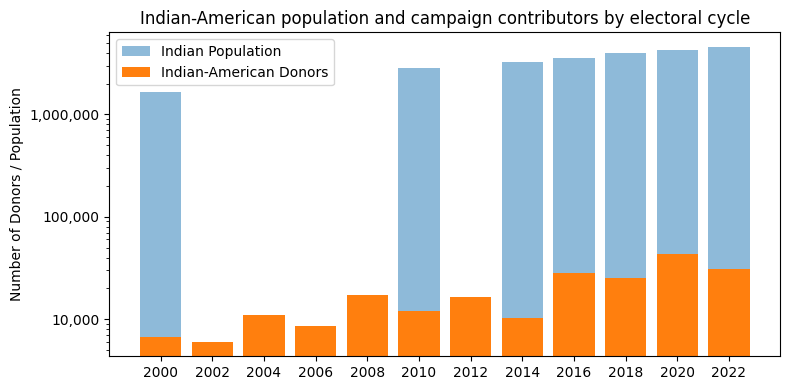

In [15]:
plt.figure(figsize=(8, 4))

cycles = pd.Series(donors_pivot["cycle"]).apply(lambda x: str(x)[:4])
plt.bar(cycles, donors_pivot['Indian Pop'], label='Indian Population', alpha=0.5)
plt.bar(cycles, donors_pivot['Indian-Americans'], label='Indian-American Donors')

plt.title("Indian-American population and campaign contributors by electoral cycle")
plt.ylabel("Number of Donors / Population")
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

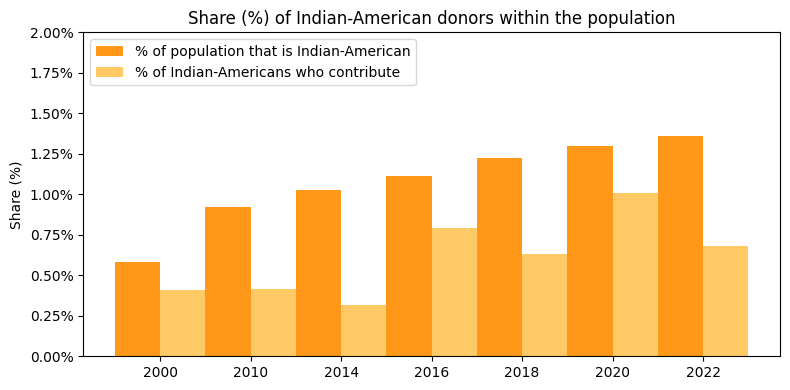

In [16]:
plt.figure(figsize=(8, 4))

cycles = pd.Series(donors_pivot["cycle"]).apply(lambda x: str(x)[:4])
cycles = cycles[~cycles.isin(['2002', '2004', '2006', '2008', '2012'])]
x = np.arange(len(cycles))
width = 0.5

plt.bar(x - width / 2, donors_pivot[~donors_pivot["cycle"].isin([2002, 2004, 2006, 2008, 2012])]['indian_pop_rate'], label='% of population that is Indian-American', alpha=0.9, width=width, color='darkorange')
plt.bar(x + width / 2, donors_pivot[~donors_pivot["cycle"].isin([2002, 2004, 2006, 2008, 2012])]['indian_rate'], label='% of Indian-Americans who contribute', alpha=0.6, width=width, color='orange')

plt.title("Share (%) of Indian-American donors within the population")
plt.ylabel("Share (%)")
plt.ylim(0, 2)
plt.xticks(x, cycles)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.2f}%'))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

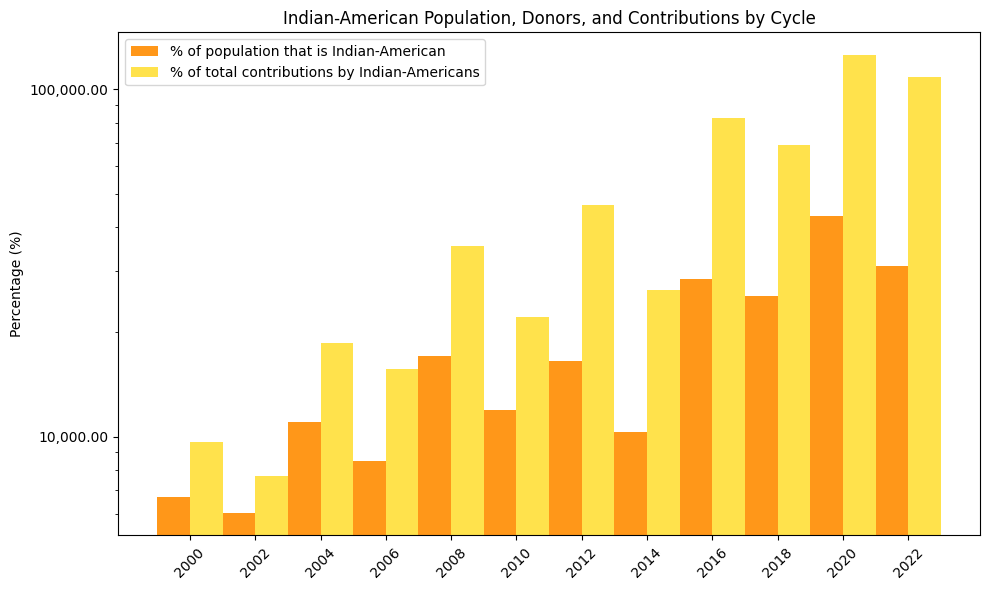

In [17]:
plt.figure(figsize=(10, 6))

# Filter and prepare the data
cycles = pd.Series(donors_pivot["cycle"]).apply(lambda x: str(x)[:4])
x = np.arange(len(cycles))
width = 0.5

# Plot the bars
plt.bar(
    x - width / 2, 
    donors_pivot['Indian-Americans'], 
    label='% of population that is Indian-American', 
    alpha=0.9, 
    width=width, 
    color='darkorange'
)

plt.bar(
    x + width / 2, 
    amounts_pivot['Indian-Americans'] / 1000,
    label='% of total contributions by Indian-Americans', 
    alpha=0.7, 
    width=width, 
    color='gold'
)

# Add labels and formatting
plt.title("Indian-American Population, Donors, and Contributions by Cycle")
plt.ylabel("Percentage (%)")
plt.yscale('log')
plt.xticks(x, cycles, rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.2f}'))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
donors_state_grouped = donors[donors["indian"] == True].groupby(['cycle', 'state']).agg({'contrib_id': 'nunique'}).reset_index()
donors_state_pivot = donors_state_grouped.pivot(index='cycle', columns='state', values='contrib_id').fillna(0)
donors_state_pivot = donors_state_pivot[['CA', 'TX', 'IL', 'NY', 'NJ', 'FL']]
donors_state_pivot

state,CA,TX,IL,NY,NJ,FL
cycle,,,,,,
2000,994.0,334.0,303.0,930.0,626.0,429.0
2002,854.0,458.0,295.0,584.0,458.0,324.0
2004,1739.0,763.0,615.0,1243.0,854.0,654.0
2006,1167.0,578.0,421.0,946.0,680.0,566.0
2008,2863.0,1184.0,971.0,1989.0,1053.0,830.0
2010,1714.0,830.0,644.0,1191.0,717.0,658.0
2012,3363.0,1197.0,917.0,1626.0,1243.0,866.0
2014,2051.0,849.0,566.0,879.0,750.0,473.0
2016,5517.0,2269.0,1681.0,2950.0,1633.0,1332.0


In [19]:
amounts_state_grouped = donors[donors["indian"] == True].groupby(['cycle', 'state']).agg({'total_donated': 'sum'}).reset_index()
amounts_state_pivot = amounts_state_grouped.pivot(index='cycle', columns='state', values='total_donated').fillna(0)
amounts_state_pivot = amounts_state_pivot[['CA', 'TX', 'IL', 'NY', 'NJ', 'FL']]
amounts_state_pivot

state,CA,TX,IL,NY,NJ,FL
cycle,,,,,,
2000,2348947.0,367505.0,421562.0,1126337.0,755989.0,563935.0
2002,1253626.0,403740.0,355863.0,777160.0,567020.0,388646.0
2004,3153653.0,913531.0,1391363.0,2415243.0,1369256.0,1297945.0
2006,2242087.0,739555.0,965492.0,2100201.0,1289763.0,961661.0
2008,6692559.0,2317387.0,2130498.0,5334241.0,2077016.0,1574807.0
2010,4192930.0,1303111.0,1221794.0,2664192.0,1235027.0,1302185.0
2012,12064424.0,3236284.0,3552260.0,5314662.0,3055783.0,2780071.0
2014,6337214.0,1733738.0,2198691.0,3093309.0,1539963.0,1242518.0
2016,18166576.0,5490149.0,9312596.0,13476534.0,4095606.0,3735090.0


In [20]:
population_state_grouped = population.groupby(['cycle', 'Code']).agg({'Indian Pop': 'sum', 'Census Pop': 'sum'}).reset_index()
population_state_grouped["state"] = population_state_grouped["Code"]

donors_state_grouped = donors[donors["indian"] == True].groupby(['cycle', 'state']).agg({'contrib_id': 'nunique'}).reset_index()
amounts_state_grouped = donors[donors["indian"] == True].groupby(['cycle', 'state']).agg({'total_donated': 'sum'}).reset_index()
donors_state_grouped = donors_state_grouped.merge(amounts_state_grouped, on=['cycle', 'state'], how='left')

donors_state_grouped = donors_state_grouped.merge(population_state_grouped, on=['cycle', 'state'], how='left')
donors_state_grouped["indian_rate"] = donors_state_grouped["contrib_id"] / donors_state_grouped["Indian Pop"] * 100
donors_state_grouped[(donors_state_grouped["state"].isin(['CA', 'TX', 'IL', 'NY', 'NJ', 'FL', 'VA', 'MA', 'WA'])) & (donors_state_grouped["cycle"] == 2020)][["state", "Indian Pop", "Census Pop", "contrib_id", "total_donated", "indian_rate"]].sort_values(by="total_donated", ascending=False)

,state,Indian Pop,Census Pop,contrib_id,total_donated,indian_rate
591,CA,806367.0,39521958.0,9453,34819173.0,1.172295
624,NY,369362.0,20105171.0,4045,14284646.0,1.095132
635,TX,436501.0,29239570.0,3811,10025452.0,0.873079
596,FL,175820.0,21592035.0,1920,8168671.0,1.092026
621,NJ,384465.0,9272794.0,2503,6316298.0,0.651035
609,MA,118912.0,6994598.0,1396,6104094.0,1.173977
603,IL,242830.0,12799088.0,2170,5789759.0,0.893629
637,VA,152302.0,8637615.0,1661,4518392.0,1.090596
640,WA,126266.0,7727209.0,1271,3877750.0,1.006605


<Figure size 1000x600 with 0 Axes>

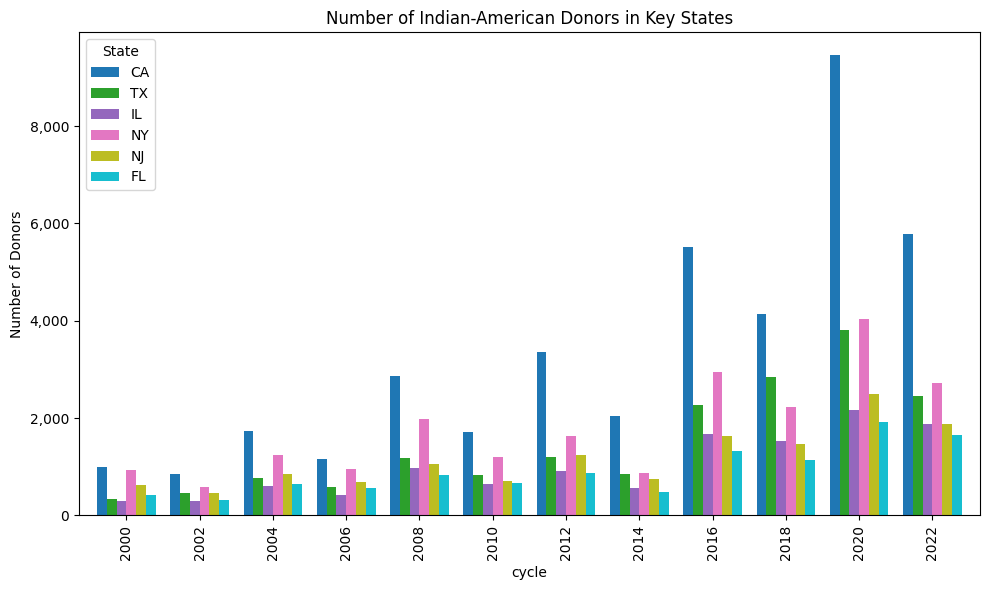

In [21]:
plt.figure(figsize=(10, 6))
donors_state_pivot.plot(kind='bar', stacked=False, figsize=(10, 6), width=0.8, colormap='tab10')
plt.title("Number of Indian-American Donors in Key States")
plt.ylabel("Number of Donors")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend(title='State', loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

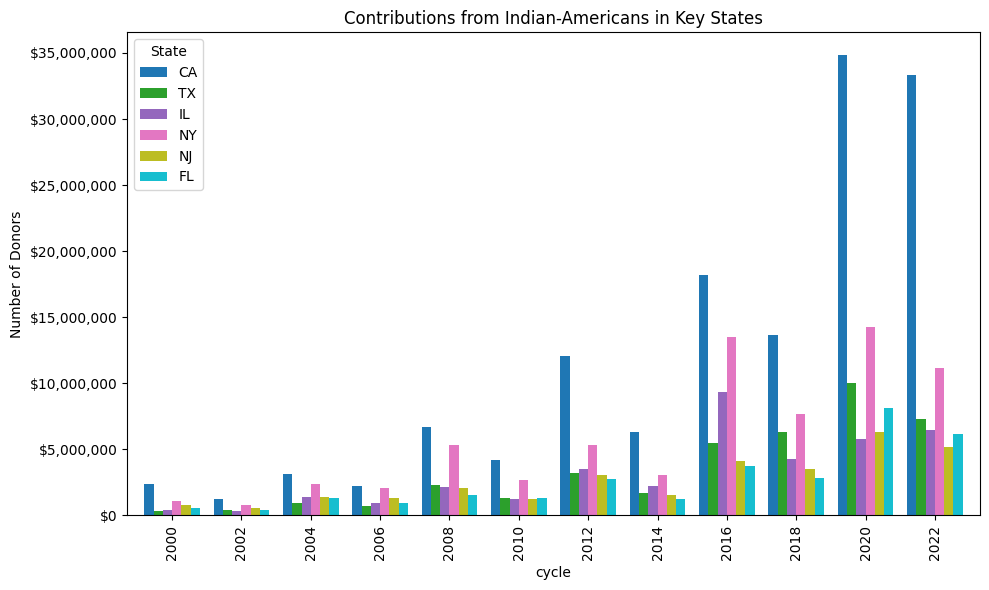

In [22]:
plt.figure(figsize=(10, 6))
amounts_state_pivot.plot(kind='bar', stacked=False, figsize=(10, 6), width=0.8, colormap='tab10')
plt.title("Contributions from Indian-Americans in Key States")
plt.ylabel("Number of Donors")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x):,}'))
plt.legend(title='State', loc='upper left')
plt.tight_layout()
plt.show()

In [23]:
top_donors = donors.sort_values(by='total_donated', ascending=False).groupby('cycle').head(10000)
top_donors["cycle"].value_counts()

cycle
2022    10000
2020    10000
2016    10000
2018    10000
2002    10000
2000    10000
2012    10000
2014    10000
2010    10000
2004    10000
2006    10000
2008    10000
Name: count, dtype: int64

In [24]:
donors_key = donors[['contrib_id', 'cycle']].apply(tuple, axis=1)
top_donors_key = top_donors[['contrib_id', 'cycle']].apply(tuple, axis=1)

donors["type"] = donors_key.isin(top_donors_key).map({True: "Top 10,000 Donors", False: "Other Donors"})
donors["type"].value_counts()

type
Other Donors         18035770
Top 10,000 Donors      120000
Name: count, dtype: int64

In [25]:
cycle_donations = (donors.groupby(['cycle', 'type'])['total_donated']
                  .sum()
                  .unstack())
cycle_percentages = cycle_donations.div(cycle_donations.sum(axis=1), axis=0) * 100
cycle_donations

type,Other Donors,"Top 10,000 Donors"
cycle,,
2000,8.892156e+08,9.586777e+08
2002,7.004416e+08,8.512325e+08
2004,1.577581e+09,6.922270e+08
2006,1.112329e+09,5.580512e+08
2008,2.449496e+09,9.334989e+08
2010,1.255336e+09,7.711021e+08
2012,2.717285e+09,2.160075e+09
2014,1.331213e+09,1.417234e+09
2016,3.083642e+09,3.666600e+09


In [26]:
# top_donors.drop_duplicates(subset=['contrib_id'], inplace=True)
# top_donors.sort_values(by='total_donated', ascending=False, inplace=True)
# top_donors.to_csv("./output/top_donors_unique.csv", index=False)

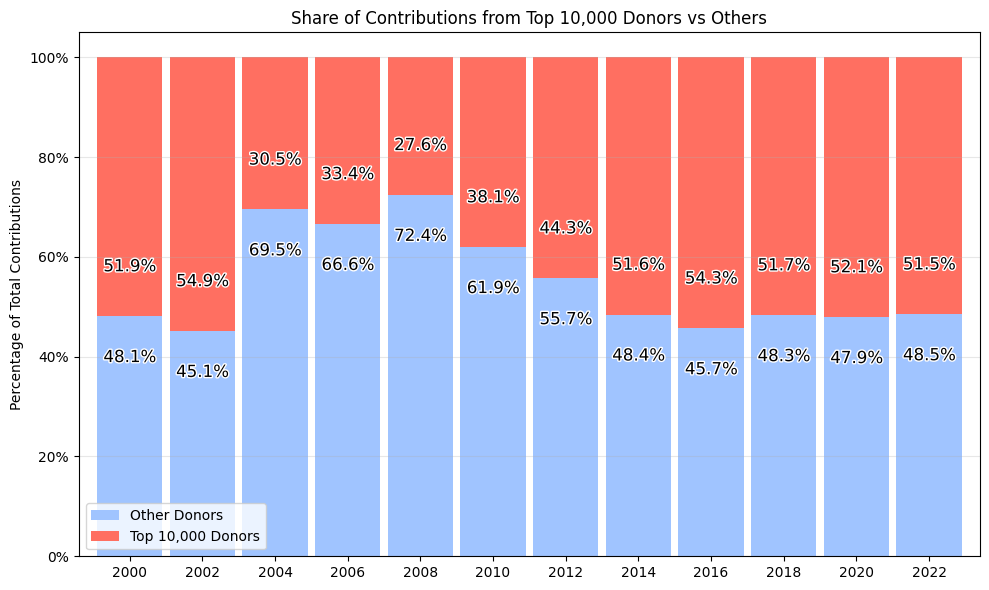

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.9
cycle_percentages.plot(kind='bar', stacked=True, color=['#A0C4FF', '#FF6F61'], width=bar_width, ax=ax)

for n, cycle in enumerate(cycle_percentages.index):
    top_pct = cycle_percentages.loc[cycle, 'Top 10,000 Donors']
    other_pct = cycle_percentages.loc[cycle, 'Other Donors']

    plt.text(n, other_pct + 10, f'{top_pct:.1f}%', ha='center', va='center', fontsize=12, color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
    plt.text(n, other_pct - 10, f'{other_pct:.1f}%', ha='center', va='bottom', fontsize=12, color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])

# Customize plot
ax.set_title('Share of Contributions from Top 10,000 Donors vs Others')
ax.set_ylabel('Percentage of Total Contributions')
ax.set_xticklabels(cycles, rotation=0)
ax.set_xlabel('')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}%'))
ax.grid(axis='y', alpha=0.3)
plt.legend(['Other Donors', 'Top 10,000 Donors'], loc='lower left', fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
donors_avg = donors.groupby(['cycle', 'indian']).agg(mean=('total_donated', 'mean'), median=('total_donated', 'median')).reset_index()
donors_avg = donors_avg.pivot(index='cycle', columns='indian', values=['mean', 'median']).fillna(0).reset_index()
donors_avg.columns = ['cycle', 'mean_other', 'mean_indian', 'median_other', 'median_indian']
donors_avg

,cycle,mean_other,mean_indian,median_other,median_indian
0,2000,2374.986051,1431.738464,650.0,600.0
1,2002,2379.822659,1271.235849,500.0,500.0
2,2004,2012.401641,1680.863690,500.0,500.0
3,2006,2145.740007,1837.969872,550.0,501.0
4,2008,2506.816482,2074.216210,721.0,750.0
5,2010,2480.478001,1856.430805,600.0,600.0
6,2012,3833.770873,2808.193392,715.0,600.0
7,2014,3724.876764,2549.860391,700.0,750.0
8,2016,2769.456964,2890.853656,360.0,500.0
9,2018,3167.996815,2720.550832,500.0,608.0


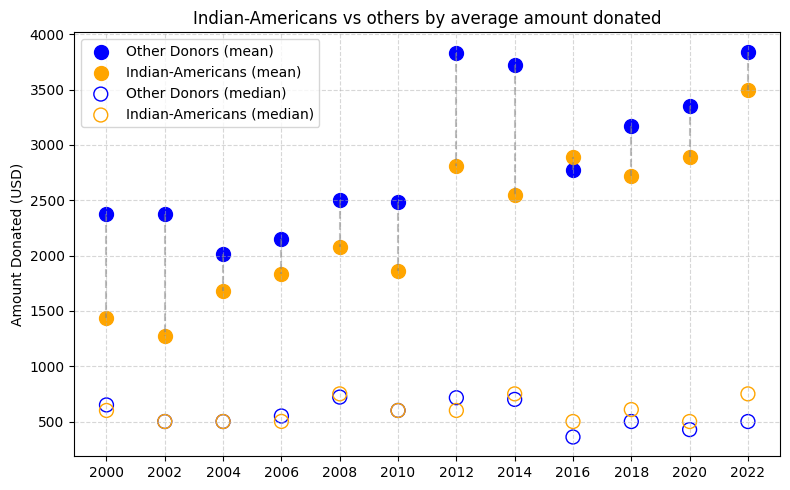

In [23]:
plt.figure(figsize=(8, 5))
cycles = pd.Series(donors_avg["cycle"]).apply(lambda x: str(x)[:4])

for cat, g1, g2 in zip(cycles, donors_avg["mean_other"], donors_avg["mean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_avg["mean_other"], color='blue', label='Other Donors (mean)', s=100)
plt.scatter(cycles, donors_avg["mean_indian"], color='orange', label='Indian-Americans (mean)', s=100)
plt.scatter(cycles, donors_avg["median_other"], facecolors='none', edgecolors='blue', label='Other Donors (median)', s=100)
plt.scatter(cycles, donors_avg["median_indian"], facecolors='none', edgecolors='orange', label='Indian-Americans (median)', s=100)

plt.title(f"Indian-Americans vs others by average amount donated")
plt.ylabel("Amount Donated (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [30]:
donors[(donors["cycle"] == 2020) & (donors["indian"] == True)][:100]["total_donated"].sum()

37464031.0

In [29]:
donors[(donors["cycle"] == 2020) & (donors["indian"] == True)]

,contrib_id,name_new,orgname,realcode,gender,occupation,city,state,total_donated,donation_count,avg_donation,med_donation,combined_ratio,indian,cycle,sector
11805965,U00000033011,vinod khosla,Khosla Ventures,F2500,M,VENTURE CAPITALIST,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,58.605447,True,2020,Finance
11806080,m0001327150,sameer gandhi,Accel Partners,F2500,M,VENTURE CAPITALIST,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,25.319363,True,2020,Finance
11806156,i30032161751,nachhattar chandi,Chandi Group Usa,F4100,M,OWNER,INDIO,CA,1311745.0,104,12612.932692,1572.5,3.843362,True,2020,Finance
11806165,h10013502001,prem reddy,Prime Healthcare Services,H1100,M,FOUNDER/CHIEF EXECUTIVE OFFICER,VICTORVILLE,CA,1297700.0,59,21994.915254,10000.0,53.515632,True,2020,Health
11806189,p00053429381,ramalinga mantena,Integra Connect,H3900,F,SELF-EMPLOYED,JUPITER,FL,1241200.0,45,27582.222222,10000.0,21.610331,True,2020,Health
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15393954,r0016248262,joyce e vinita,Retired,X1200,F,RETIRED,EDINBURG,TX,1.0,1,1.000000,1.0,33.821583,True,2020,NaN
15393969,r0021476571,theophil schmitt,Retired,X1200,M,RETIRED,GREENVILLE,SC,1.0,1,1.000000,1.0,15.853867,True,2020,NaN
15394009,r0016318327,phyllis a bende,NaN,Y2000,F,INFORMATION REQUESTED PER BEST EFFORTS,TABERNACLE,NJ,1.0,1,1.000000,1.0,17.028228,True,2020,Unknown
15394097,r0022575130,gilmer d apaka,NaN,Y2000,M,NaN,VACAVILLE,CA,1.0,1,1.000000,1.0,1000.000000,True,2020,Unknown


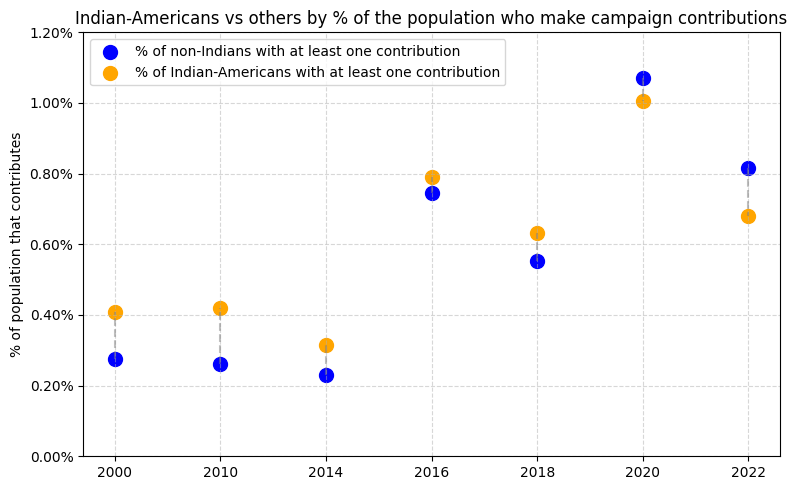

In [18]:
plt.figure(figsize=(8, 5))
cycles = pd.Series(donors_pivot["cycle"]).apply(lambda x: str(x)[:4])
cycles = cycles[~cycles.isin(['2002', '2004', '2006', '2008', '2012'])]

for cat, g1, g2 in zip(cycles, donors_pivot[~donors_pivot["cycle"].isin([2002, 2004, 2006, 2008, 2012])]["other_rate"], donors_pivot[~donors_pivot["cycle"].isin([2002, 2004, 2006, 2008, 2012])]["indian_rate"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_pivot[~donors_pivot["cycle"].isin([2002, 2004, 2006, 2008, 2012])]["other_rate"], color='blue', label='% of non-Indians with at least one contribution', s=100)
plt.scatter(cycles, donors_pivot[~donors_pivot["cycle"].isin([2002, 2004, 2006, 2008, 2012])]["indian_rate"], color='orange', label='% of Indian-Americans with at least one contribution', s=100)

plt.title(f"Indian-Americans vs others by % of the population who make campaign contributions")
plt.ylabel("% of population that contributes")
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.2f}%'))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [32]:
sectors_avg = donors[(donors["cycle"] == 2000 + year) & (~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"]))].groupby(['sector', 'indian']).agg(mean=('total_donated', 'mean'), median=('total_donated', 'median')).reset_index()
sectors_avg = sectors_avg.pivot(index='sector', columns='indian', values=['mean', 'median']).fillna(0).reset_index()
sectors_avg.columns = ['sector', 'mean_other', 'mean_indian', 'median_other', 'median_indian']
sectors_avg

,sector,mean_other,mean_indian,median_other,median_indian
0,Agribusiness,3046.342166,5785.355422,512.0,787.0
1,Construction,2695.004117,3930.402685,500.0,500.0
2,Defense,1823.233689,1665.597222,495.0,455.0
3,Education,1047.379357,1221.653214,249.0,350.0
4,Energy,3469.208389,1809.778388,500.0,500.0
5,Finance,6519.427552,8000.754618,500.0,700.0
6,Health,2067.587930,3073.753070,375.0,500.0
7,Labor,694.222414,400.267267,229.0,160.0
8,Law,3912.009174,2940.651852,750.0,750.0
9,Manufacturing,5828.760668,5821.995338,500.0,708.0


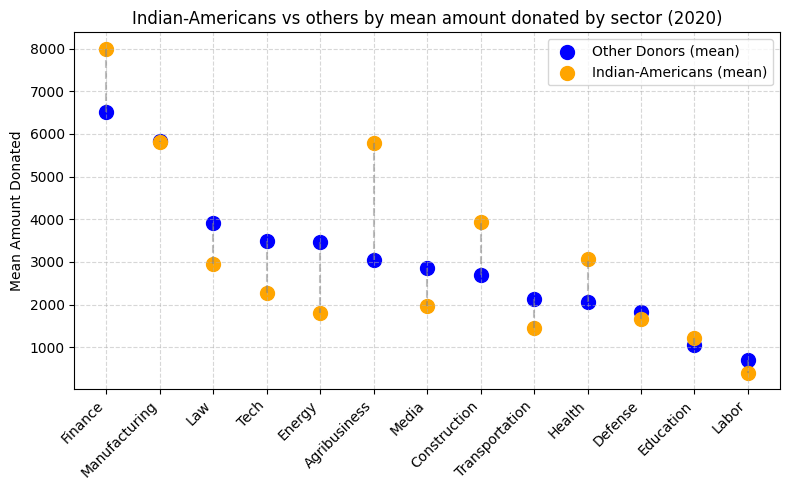

In [33]:
plt.figure(figsize=(8, 5))

sectors_avg = sectors_avg.sort_values(by='mean_other', ascending=False)
sectors = sectors_avg["sector"].tolist()

for cat, g1, g2 in zip(sectors, sectors_avg["mean_other"], sectors_avg["mean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, sectors_avg["mean_other"], color='blue', label='Other Donors (mean)', s=100)
plt.scatter(sectors, sectors_avg["mean_indian"], color='orange', label='Indian-Americans (mean)', s=100)

plt.title(f"Indian-Americans vs others by mean amount donated by sector (20{year})")
plt.ylabel("Mean Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

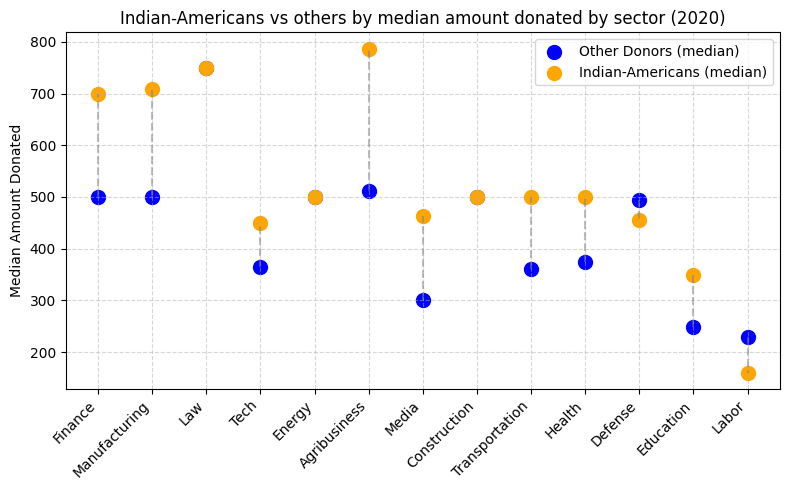

In [34]:
plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, sectors_avg["median_other"], sectors_avg["median_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, sectors_avg["median_other"], color='blue', label='Other Donors (median)', s=100)
plt.scatter(sectors, sectors_avg["median_indian"], color='orange', label='Indian-Americans (median)', s=100)

plt.title(f"Indian-Americans vs others by median amount donated by sector (20{year})")
plt.ylabel("Median Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [35]:
# statistical tests

model = ols('total_donated ~ C(indian) + C(sector)', data=donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq         df           F         PR(>F)
C(indian)  1.311579e+09        1.0    0.089780   7.644570e-01
C(sector)  1.873292e+13       12.0  106.858581  3.405244e-267
Residual   1.183969e+17  8104490.0         NaN            NaN


In [36]:
tukey = pairwise_tukeyhsd(endog=donors[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["total_donated"].notnull())]['total_donated'],
                         groups=donors[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["total_donated"].notnull())]['indian'],
                         alpha=0.05)
print(tukey.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
 False   True -101.7948 0.7133 -644.8841 441.2945  False
--------------------------------------------------------


In [37]:
sectors_count = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'sector', 'indian']).agg(sum=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index()
sectors_count_pivot = sectors_count.pivot(index=['cycle', 'sector'], columns='indian', values=['sum', 'count']).fillna(0).reset_index()
sectors_count_pivot.columns = ['cycle', 'sector', 'sum_other', 'sum_indian', 'count_other', 'count_indian']
sectors_count_pivot

,cycle,sector,sum_other,sum_indian,count_other,count_indian
0,2000,Agribusiness,28856388.0,94645.0,20063.0,71.0
1,2000,Construction,55638450.0,448211.0,31709.0,226.0
2,2000,Defense,4521375.0,34866.0,2979.0,26.0
3,2000,Education,832185.0,5600.0,1229.0,9.0
4,2000,Energy,35955972.0,171888.0,13660.0,92.0
...,...,...,...,...,...,...
151,2022,Law,403874052.0,3628516.0,71604.0,627.0
152,2022,Manufacturing,190172603.0,2238323.0,17485.0,338.0
153,2022,Media,82611712.0,661464.0,20187.0,170.0
154,2022,Tech,381060139.0,5461762.0,58128.0,1752.0


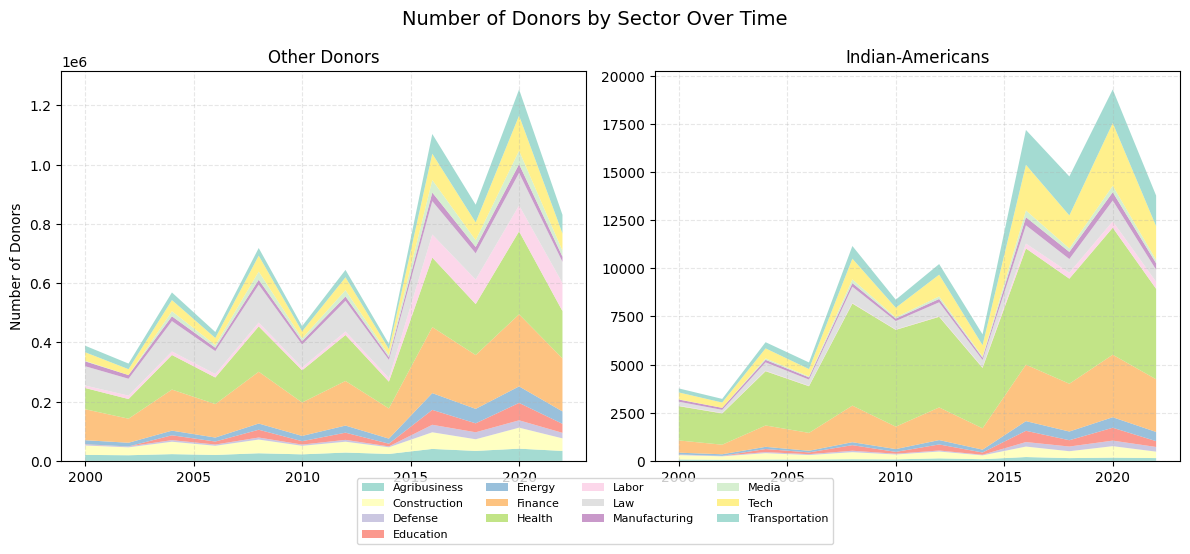

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

sectors = sectors_count_pivot["sector"].unique()
colors = sns.color_palette("Set3", n_colors=len(sectors))

count_other = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_other')
count_indian = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_indian')

ax1.stackplot(
    count_other.index,
    count_other.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors", fontsize=12)
ax1.set_ylabel("Number of Donors")
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_indian.index,
    count_indian.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Number of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

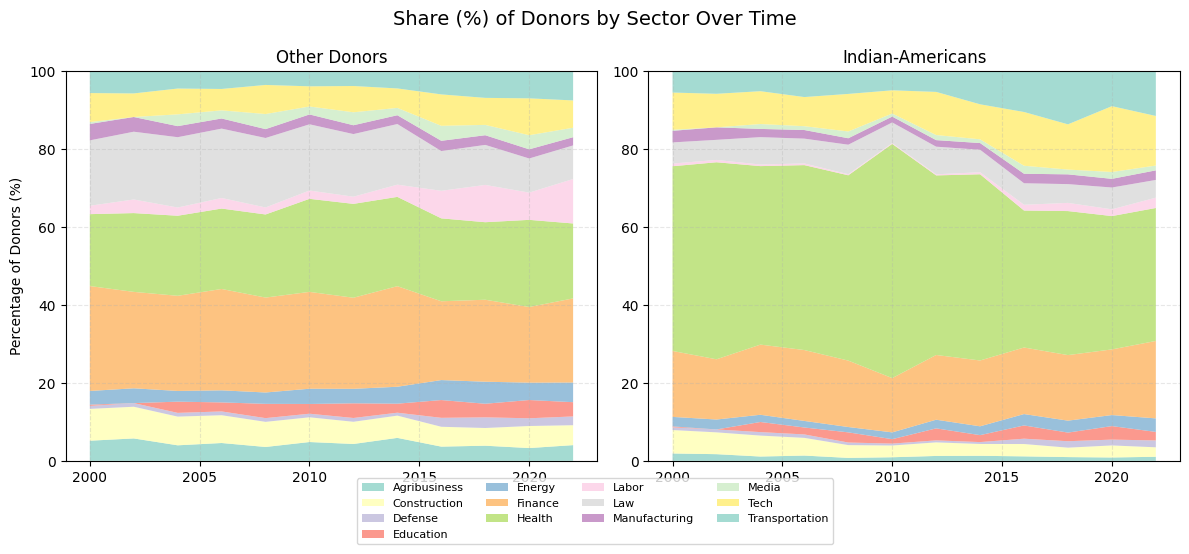

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

sectors = sectors_count_pivot["sector"].unique()
colors = sns.color_palette("Set3", n_colors=len(sectors))

count_other = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_other')
count_other = count_other.div(count_other.sum(axis=1), axis=0) * 100
count_indian = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_indian')
count_indian = count_indian.div(count_indian.sum(axis=1), axis=0) * 100

ax1.stackplot(
    count_other.index,
    count_other.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors", fontsize=12)
ax1.set_ylabel("Percentage of Donors (%)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_indian.index,
    count_indian.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_ylim(0, 100)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

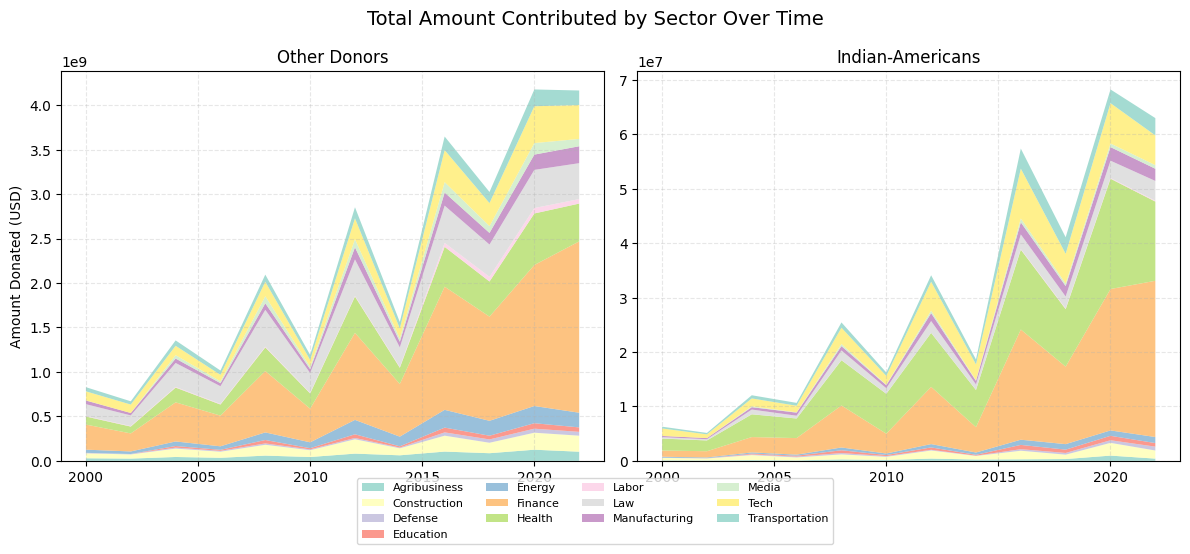

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

sectors = sectors_count_pivot["sector"].unique()
colors = sns.color_palette("Set3", n_colors=len(sectors))

sum_other = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_other')
sum_indian = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_indian')

ax1.stackplot(
    sum_other.index,
    sum_other.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors", fontsize=12)
ax1.set_ylabel("Amount Donated (USD)")
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian.index,
    sum_indian.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Total Amount Contributed by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

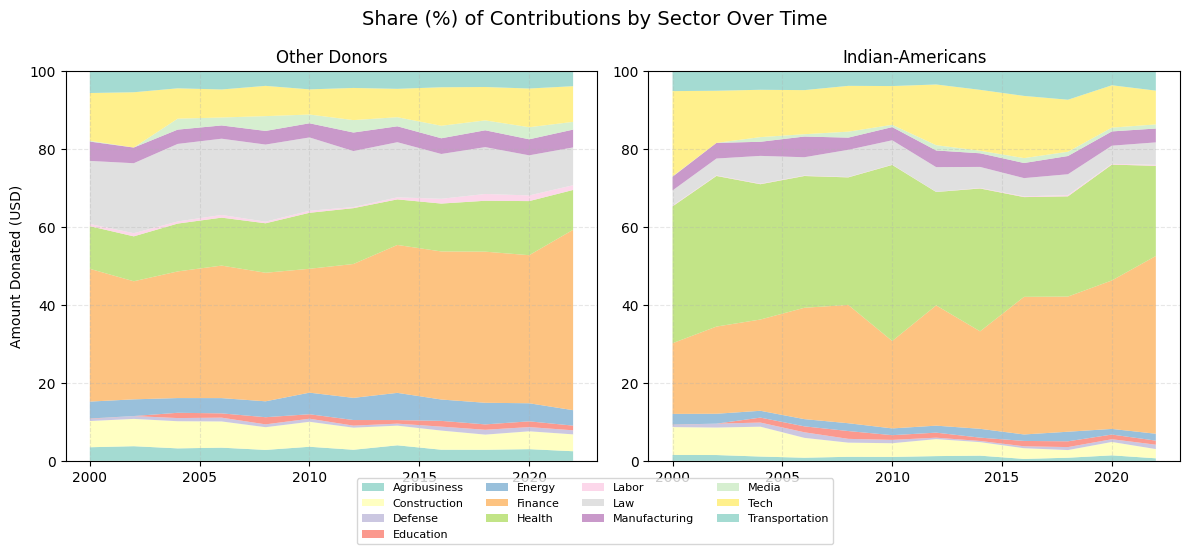

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

sectors = sectors_count_pivot["sector"].unique()
colors = sns.color_palette("Set3", n_colors=len(sectors))

sum_other = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_other')
sum_other = sum_other.div(sum_other.sum(axis=1), axis=0) * 100
sum_indian = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_indian')
sum_indian = sum_indian.div(sum_indian.sum(axis=1), axis=0) * 100

ax1.stackplot(
    sum_other.index,
    sum_other.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors", fontsize=12)
ax1.set_ylabel("Amount Donated (USD)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian.index,
    sum_indian.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_ylim(0, 100)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Contributions by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [42]:
key_states = ['CA', 'TX', 'IL', 'NY', 'NJ', 'FL', 'VA', 'MA', 'WA']

states_count = donors.groupby(['cycle', 'state', 'indian']).agg(sum=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index()
states_count_pivot = states_count.pivot(index=['cycle', 'state'], columns='indian', values=['sum', 'count']).fillna(0).reset_index()
states_count_pivot.columns = ['cycle', 'state', 'sum_other', 'sum_indian', 'count_other', 'count_indian']

states_count_pivot['state'] = states_count_pivot['state'].where(states_count_pivot['state'].isin(key_states), 'Others')
states_count_pivot = states_count_pivot.groupby(['cycle', 'state']
).agg({
    'sum_other': 'sum',
    'sum_indian': 'sum',
    'count_other': 'sum',
    'count_indian': 'sum'
}).reset_index()

states_count_pivot

,cycle,state,sum_other,sum_indian,count_other,count_indian
0,2000,CA,1.780421e+08,2348947.0,86437.0,994.0
1,2000,FL,8.021023e+07,563935.0,43421.0,429.0
2,2000,IL,5.204146e+07,421562.0,31032.0,303.0
3,2000,MA,3.766730e+07,178338.0,20242.0,138.0
4,2000,NJ,5.874741e+07,755989.0,35502.0,626.0
...,...,...,...,...,...,...
115,2022,NY,1.037826e+09,11162687.0,167740.0,2722.0
116,2022,Others,3.554897e+09,28699339.0,1406645.0,11822.0
117,2022,TX,6.165521e+08,7304024.0,191167.0,2459.0
118,2022,VA,2.472069e+08,4570372.0,86930.0,1144.0


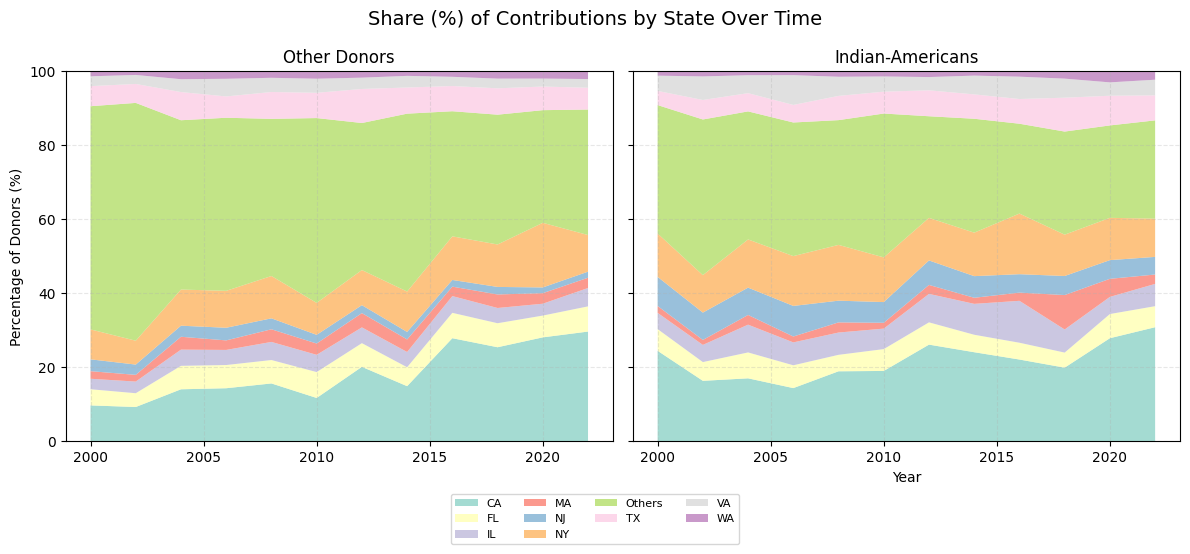

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

state_names = states_count_pivot["state"].unique()
colors = sns.color_palette("Set3", n_colors=len(state_names))

sum_other = states_count_pivot.pivot(index='cycle', columns='state', values='sum_other')
sum_other = sum_other.div(sum_other.sum(axis=1), axis=0) * 100
sum_indian = states_count_pivot.pivot(index='cycle', columns='state', values='sum_indian')
sum_indian = sum_indian.div(sum_indian.sum(axis=1), axis=0) * 100

ax1.stackplot(
    sum_other.index,
    sum_other.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors", fontsize=12)
ax1.set_ylabel("Percentage of Donors (%)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian.index,
    sum_indian.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_xlabel("Year")
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Contributions by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [34]:
donors[(donors["indian"] == True) & (donors["cycle"] == 2020)].groupby("sector").agg(total_donated=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index().sort_values(by='total_donated', ascending=False)

,sector,total_donated,count
12,Party,29333191.0,8816
5,Finance,25986451.0,3248
6,Health,20277549.0,6597
15,Unknown,12373984.0,7173
13,Tech,7412433.0,3258
7,Ideology/Single Issue,5690983.0,2942
9,Law,3175904.0,1080
14,Transportation,2517317.0,1745
10,Manufacturing,2497636.0,429
1,Construction,2342520.0,596
